# Download data and libs

In [ ]:
!pip install gdown
!gdown --id 1_9NPC8E-kt4pU6rTi5lkh91eFR_jnFav --output sino_nom.zip
!unzip -u '/kaggle/working/sino_nom.zip'

In [ ]:
!pip install numpy-stl

# Processing 3D STL models

In [1]:
g_path = 'wb_2D3Dretrieval_dataset/pairs'

In [2]:
import numpy as np
from stl import mesh
import os
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
import io
import cv2

img_size = (256,256)
def crop(image):
    contours, hierarchy = cv2.findContours(image ,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)[-2:]
    cropped_image = None

    min_x = min_y = float('inf')
    max_x = max_y = 0

    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        if x==0 or y==0:
            continue
        # Tìm tọa độ min-max
        min_x = min(min_x, x)
        min_y = min(min_y, y)
        max_x = max(max_x, x + w)
        max_y = max(max_y, y + h)
    return cv2.resize(image[min_y:max_y, min_x:max_x], img_size)  

def stl_to_2d(file_path):
    # Load the STL file
    _mesh = mesh.Mesh.from_file(file_path)
    # Compute the bounding box
    min_coords = np.min(_mesh.points, axis=0)
    max_coords = np.max(_mesh.points, axis=0)
    # Choose a cutting axis (e.g., the z-axis)
    cutting_axis = 2  # Assuming z-axis, change if needed
    # Find the coordinate value halfway between the minimum and maximum along the cutting axis
    cutting_plane = min_coords[cutting_axis] + 6*(max_coords[cutting_axis] - min_coords[cutting_axis]) / 7.0
    # Partition the model based on the cutting plane
    vectors_above_plane = []
    for vector in _mesh.vectors:
        # Check if all vertices of the triangle are above the cutting plane
        if np.all(vector[:, cutting_axis] > cutting_plane):
            vectors_above_plane.append(vector)
    # Create a new mesh object from the vectors above the cutting plane
    above_cutting_plane_mesh = mesh.Mesh(np.zeros(len(vectors_above_plane), dtype=mesh.Mesh.dtype))
    above_cutting_plane_mesh.vectors = vectors_above_plane

    figure = plt.figure()
    axes = figure.add_subplot(projection='3d')
    axes.view_init(elev=90, azim=-90)
    # Load the STL files and add the vectors to the plot
    poly_collection = mplot3d.art3d.Poly3DCollection(above_cutting_plane_mesh.vectors)
    poly_collection.set_color((0,0,0))  # play with color
    scale = above_cutting_plane_mesh.points.flatten()
    axes.auto_scale_xyz(scale, scale, scale)
    axes.add_collection3d(poly_collection)
    plt.grid(False)
    plt.axis('off')
    # Show the plot to the screen
    buffer = io.BytesIO()
    figure.savefig(buffer, format='jpg')
    buffer.seek(0)
    image_buffer = cv2.imdecode(np.frombuffer(buffer.getvalue(), dtype=np.uint8), -1)
    gray = cv2.cvtColor(image_buffer, cv2.COLOR_BGR2GRAY)
    ret,thresh_3d = cv2.threshold(gray,150,255,0)
    image_ = crop(thresh_3d)
    buffer.close()
    plt.close()
    return image_
    

(<matplotlib.image.AxesImage at 0x2751ea34250>, (-0.5, 255.5, 255.5, -0.5))

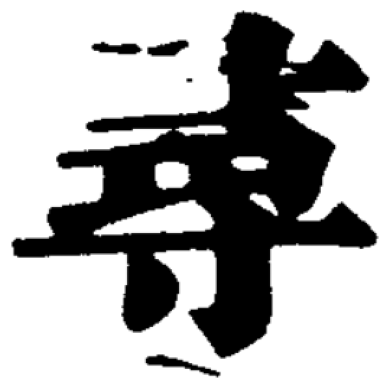

In [3]:
plt.imshow(stl_to_2d('wb_2D3Dretrieval_dataset/database/26.stl'), cmap = 'gray'), plt.axis('off')

In [ ]:

stl_path = os.path.join(g_path,'stl') 
stl_2d_path = os.path.join(g_path,'stl_to_2d_pairs')
if not os.path.exists(stl_2d_path):
    os.mkdir(stl_2d_path) 
index=1
num_file= len(os.listdir(stl_path))
for file in os.listdir(stl_path): 
    print(f'{index}/{num_file}')
    index+=1
    path = os.path.join(stl_path,file)
    img_2d = stl_to_2d(path)
    out_path = os.path.join(stl_2d_path,file+'.png') 
    cv2.imwrite(out_path, img_2d)

# Processing 2D images

In [3]:
def process_2d(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret,thresh_2d = cv2.threshold(gray,150,255,0)
    return crop(thresh_2d)

# Find top 5 3D models most similar to 2D image

In [4]:
def find_similar(img_path):
    stl_2d_folder = stl_2d_path
    input_image = process_2d(cv2.imread(img_path))
    binary_images_folder = stl_2d_path
    image_matches = []

    for filename in os.listdir(binary_images_folder):
        image_path = os.path.join(binary_images_folder, filename)
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

        # So khớp mẫu ảnh
        match = cv2.matchTemplate(image, input_image, cv2.TM_CCOEFF_NORMED)
        image_matches.append((filename, match.max()))

    sorted_images = sorted(image_matches, key=lambda x: x[1], reverse=True)
    top_5 = [path for path, match_value in sorted_images[:5]]
    return top_5

# Write to csv file

In [5]:
stl_path = os.path.join(g_path,'stl') 
stl_2d_path = os.path.join(g_path,'stl_to_2d_pairs')
num_file= len(os.listdir(stl_path))

In [ ]:
# Create the label csv file
f = open("wb_2D3Dretrieval_dataset/pairs/labels_pairs.csv", "w") # test_hog_512.csv

queries_path =  os.path.join(g_path,'print') 

num_queries = len(os.listdir(queries_path))
for filename in os.listdir(queries_path):
    f.write(filename + ',"' + filename.replace("png", "stl") + '"' +'\n')
f.close()

In [10]:
f = open("wb_2D3Dretrieval_dataset/pairs/test_template.csv", "w")
f.write('query,label\n')
print(g_path)
queries_path =  os.path.join(g_path,'print') 
index = 1
num_queries = len(os.listdir(queries_path))
for filename in os.listdir(queries_path):
    print(f'{index}/{num_queries}')
    index+=1
    img_path = os.path.join(queries_path,filename) 
    top5 = find_similar(img_path)
    top5_tostring = ','.join([n[:-4] for n in top5])
    f.write(filename + ',"' + top5_tostring +'"'+'\n')
f.close()

wb_2D3Dretrieval_dataset/pairs
1/228
2/228
3/228
4/228
5/228
6/228
7/228
8/228
9/228
10/228
11/228
12/228
13/228
14/228
15/228
16/228
17/228
18/228
19/228
20/228
21/228
22/228
23/228
24/228
25/228
26/228
27/228
28/228
29/228
30/228
31/228
32/228
33/228
34/228
35/228
36/228
37/228
38/228
39/228
40/228
41/228
42/228
43/228
44/228
45/228
46/228
47/228
48/228
49/228
50/228
51/228
52/228
53/228
54/228
55/228
56/228
57/228
58/228
59/228
60/228
61/228
62/228
63/228
64/228
65/228
66/228
67/228
68/228
69/228
70/228
71/228
72/228
73/228
74/228
75/228
76/228
77/228
78/228
79/228
80/228
81/228
82/228
83/228
84/228
85/228
86/228
87/228
88/228
89/228
90/228
91/228
92/228
93/228
94/228
95/228
96/228
97/228
98/228
99/228
100/228
101/228
102/228
103/228
104/228
105/228
106/228
107/228
108/228
109/228
110/228
111/228
112/228
113/228
114/228
115/228
116/228
117/228
118/228
119/228
120/228
121/228
122/228
123/228
124/228
125/228
126/228
127/228
128/228
129/228
130/228
131/228
132/228
133/228
134/228
135/2

# Test

In [16]:
img_file_name = '98.png'
img1_path = os.path.join(queries_path, img_file_name)
# In ra đường dẫn của 5 ảnh tương tự nhất
top_5 = find_similar(img1_path)
for image_path in top_5:
    print(image_path)

98.stl.png
203.stl.png
144.stl.png
184.stl.png
136.stl.png


## Top 5 model 3D tìm được

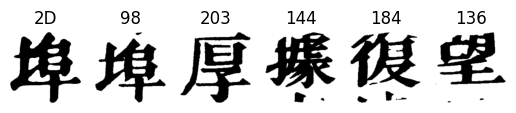

In [17]:
img2d = [cv2.imread(os.path.join(stl_2d_path,p)) for p in top_5]
plt.subplot(161),plt.imshow(process_2d(cv2.imread(img1_path)),cmap = 'gray'),plt.title('2D')
plt.axis('off')
plt.subplot(162),plt.imshow(img2d[0]),plt.title(top_5[0][:-8])
plt.axis('off')
plt.subplot(163),plt.imshow(img2d[1]),plt.title(top_5[1][:-8])
plt.axis('off')
plt.subplot(164),plt.imshow(img2d[2]),plt.title(top_5[2][:-8])
plt.axis('off')
plt.subplot(165), plt.imshow(img2d[3]),plt.title(top_5[3][:-8])
plt.axis('off')
plt.subplot(166),plt.imshow(img2d[4]),plt.title(top_5[4][:-8])
plt.axis('off')
plt.show()